## Random sampling the IGIMF with a varying IMF (ECMF and IMF random!)

I want to investigate in this file the form of a composite IMF when the ECMF as well as the IMF are randomly sampled functions. (I could also test the case, when the ECMF is optimally sampled, but the stellar IMF is random sampled.) The sampling method influences the resulting functional form as shown by Haas and Anders (2010)

### Part 1: Optimal ECMF, random stellar IMF

In [3]:
### Definde the functions I need to randomly sample from a stellar IMF

import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.optimize import root_scalar

## The function_alpha_chamge functions describe the change of the stellar IMF

def function_alpha_1_change(alpha1_model, M_over_H):
    alpha_1 = 1.3
    if (alpha1_model == 0):
        return alpha_1
    elif (alpha1_model == 1):
        alpha_1_change = alpha_1 + 0.5 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'IGIMF2.5'):
        alpha_1_change = alpha_1 + 0.12 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'Z_MW'):
        alpha_1_change = alpha_1 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        return alpha_1_change
    elif (alpha1_model == 'Z'):
        alpha_1_change = alpha_1 + 63 * (10**M_over_H - 1) * 0.0142
        return alpha_1_change
    else:
        print('Invalid Input for alpha1 model')
        return

## Function to change alpha_2 depending on the model; imported from galimf.py
def function_alpha_2_change(alpha2_model, M_over_H):
    alpha_2=2.3
    if (alpha2_model == 0):
        return alpha_2
    elif (alpha2_model == 1):
        alpha_2_change = alpha_2 + 0.5 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'Z_MW'):
        alpha_2_change = alpha_2 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'Z'):
        alpha_2_change = alpha_2 + 63 * (10**M_over_H - 1) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'IGIMF2.5'):
        alpha_2_change = alpha_2 + 0.12 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'R14'):
        alpha_2_change = 2.3 + 0.0572 * M_over_H
        return alpha_2_change
    else:
        print('Invalid input for alpha2 model')
        return

def function_alpha_3_change(alpha3_model, M_ecl, M_over_H):
    ## M_ecl is the mass of the cluster
    ## M_over_H is the metallicity of the cluster, but apparently is in reality [Z]
    ## since the formula for model 2 is similar to the formula from Yan et al.(2021)
    ## where [Z] is used, I assume that M_over_H is actually [Z]
    ## alpha3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
    if (alpha3_model == 0):
        default_alpha3 = 2.3
        # print("alpha_3 is set to be a constant: %s, as this is the default alpha_3 value for alpha3_model 0.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (default_alpha3))
        return default_alpha3
    elif (alpha3_model == 1):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        if rho < 9.5 * 10 ** 4:
            alpha_3_change = 2.3
        else:
            alpha_3_change = 1.86 - 0.43 * math.log(rho / 10 ** 6, 10)
        # print("Notification in file 'alpha3_model' uncompleted")
        if alpha_3_change < 0.5:
            print("IMF alpha_3 being", alpha_3_change, "out of the tested range from Marks et al. 2012.")
        return alpha_3_change
    elif (alpha3_model == 2):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        x = -0.14 * M_over_H + 0.99 * math.log(rho / 10 ** 6, 10)
        if x < -0.87:
            alpha_3_change = 2.3
        else:
            alpha_3_change = -0.41 * x + 1.94
        # print("Notification in file 'alpha3_model' uncompleted")
        return alpha_3_change
    elif (alpha3_model == 'R14'):
        alpha_3_change = 2.3 + 0.0572 * M_over_H
        return alpha_3_change
    else:
        # print("alpha_3 is set to be a constant: %s, as this is the input value of parameter 'alpha3_model'.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (alpha3_model))
        return alpha3_model
    
#### This function random samples from a three part-power law IMF
#### The IMF is taken as varying IMF

def draw_IMF_mod(M_ecl):

    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=150.0 

    alpha_1_model='Z'
    alpha_2_model='Z'
    Metallicity=-0.37
    alpha_3_model=2

    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)

    ### could implement the alpha_3_model function here
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

    Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
    Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
    Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

    #k=1/(Term_1+Term_2+Term_3)
    #k_1=k
    #k_2=0.5*k
    #k_3=0.5*k 

    k_1 = 1/(Term_1+Term_2+Term_3)
    k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)
    
    ## X_1, representing the random variable at which the first part of the power law ends
   ## X_1= scipy.integrate.quad(xi, m_0, m_1)[0]

    X_1=k_1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
    ## print(X_1)

    ## X_2, here being taken as the integral of the power law from m_1 to m_2
    ## The second part of the power law ends at the i
    # ntegral from m_0 to m_2, so at X_1+X_2
  ##  X_2= scipy.integrate.quad(xi, m_1, m_2)[0]

    X_2=k_2/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
   ## print(X_1+X_2)

    ## X_3, here being taken as the integral of the power law from m_2 to m_max
    ## The third part of the power law ends at the integral from m_0 to m_max, so at X_1+X_2+X_3
    ## The sum of X_1+X_2+X_3 should be unity
   ## X_3= scipy.integrate.quad(xi, m_2, m_max)[0]

    X_3=k_3/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))
    ##print(X_1+X_2+X_3)


    m_array=([])
    while np.sum(m_array)<M_ecl:

        ### Should I let code stop before total mass could get larger than M_ecl?
        ### Or maybe check which case(Adding or not adding the last star) is closer?

        ###draw new random number between zero and one
        X=np.random.uniform(0,1)

        ## when X<X_1 the mass is drawn from the first power law

        ### write code such that the mass of the last star is added dependent on if the total mass is then closer to M_ecl

        if X < X_1:
            m=((1-alpha_1)*X/k_1+m_0**(1-alpha_1))**(1/(1-alpha_1))
            m_array=np.append(m_array,m)
        
        ## when X>=X_1 and X<X_1+X_2 the mass is drawn from the second power law
        elif X >= X_1 and X < X_1+X_2:
            m=((1-alpha_2)*(X-X_1)/k_2+m_1**(1-alpha_2))**(1/(1-alpha_2))
            m_array=np.append(m_array,m)
        
        ## when X>=X_1+X_2 and X<X_1+X_2+X_3 the mass is drawn from the third power law
        elif X >= X_1+X_2 and X < X_1+X_2+X_3:
            m=((1-alpha_3)*(X-X_1-X_2)/k_3+m_2**(1-alpha_3))**(1/(1-alpha_3))
            m_array=np.append(m_array,m)

        if np.sum(m_array)>M_ecl:
            ## if there is only one star in the cluster that is too massive for the cluster mass, redraw
            if len(m_array)==1:
                m_array=([])
            ## if adding the last star would make the discrepany to M_ecl larger then the last star is not added
            elif np.sum(m_array)-M_ecl>M_ecl-np.sum(m_array[:-1]):
                m_array=np.delete(m_array,-1)
                break

    return m_array

In [4]:
## define power law MLE as test function

def MLE_with_std(data):

    Y=np.min(data)
    Z=np.max(data)
    T=np.sum(np.log(data))
    n=len(data)

    ## Does this really determine the exponent I look for?
    def Determinator(alpha_ML):  
        eq1 = -n/(1-alpha_ML)
        eq2 = n*(Z**(1-alpha_ML)*np.log(Z)-Y**(1-alpha_ML)*np.log(Y))/(Z**(1-alpha_ML)-Y**(1-alpha_ML))-T
        return eq1+eq2
        
    sol = root_scalar(Determinator, bracket=[-30.0, 0.999*30.0])
    slope = sol.root
    slope_unbiased=(n)/(n-2)*(slope-1)+1 ## According to Maschberger& Kroupa (2009)

    
    Fisher_information_wrong=-n*(-slope_unbiased/(1-slope_unbiased)**2+(slope_unbiased-1)*Y**(-slope_unbiased)*Z**(-slope_unbiased)*(Z-Y)*(np.log(Z)-np.log(Y))/(Z**(1-slope_unbiased)-Y**(1-slope_unbiased))**2)

    Fisher_information=n*(slope_unbiased/(1-slope_unbiased)**2+(Y**(1-slope_unbiased)*Z**(1-slope_unbiased)*((np.log(Z)-np.log(Y))**2))/(Z**(1-slope_unbiased)-Y**(1-slope_unbiased))**2)

    Variance=1/(n*Fisher_information)
    SE=np.sqrt(Variance) ### This is the standard error!! Not the standard deviation!
    std=np.sqrt(1/Fisher_information)


    return slope_unbiased, std

In [5]:
### I can just import the ECMF for various beta powerlaws

### These are the most massive clusters in the LMC all stacked together in 30Dor
ECMF_beta_2=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_2_PL.txt')

print(MLE_with_std(ECMF_beta_2))

(2.006251627550677, 0.05668897479826146)


In [6]:
i=0
masses=np.array([])
while i<len(ECMF_beta_2):
    masses=np.append(masses,draw_IMF_mod(ECMF_beta_2[i]))
    print(ECMF_beta_2[i])
    i+=1

49999.945898347054


KeyboardInterrupt: 

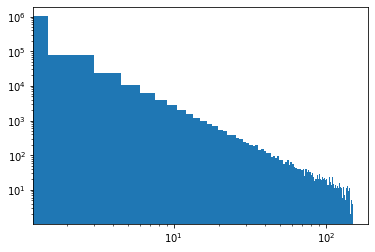

In [9]:
plt.hist(masses, bins=100, range=(0,150))
plt.xscale('log')
plt.yscale('log')

In [10]:
print(MLE_with_std(masses[masses>1]))
print(MLE_with_std(masses[masses>15]))

(2.1755500888433343, 0.001663101480179141)
(2.1584906212553308, 0.007567016898237101)


In [ ]:
### For all clusters in the LMC

ECMF_beta_2_LMC=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_2_PL_all_1SM_stars.txt')

### I could just use the clusters more massive than 15 solar masses
### if I am only interestd in m>15 Msolar to speed up the calculations

In [14]:
i=0
masses_LMC=np.array([])
while i<len(ECMF_beta_2_LMC):
    masses_LMC=np.append(masses_LMC,draw_IMF_mod(ECMF_beta_2_LMC[i]))
    print(ECMF_beta_2_LMC[i])
    i+=1

49999.945898347054
44803.76070374504
40586.638175768174
37095.53562360976
34157.735428750224
31651.302655516887
29487.692298669852
27601.048822953097
25941.37400524204
24470.02389187423
23156.65812452558
21977.12289691063
20911.950307961746
19945.274385417724
19064.034753808006
18257.382654805377
17516.23176076556
16832.914205553756
16200.91415604534
15614.659267376795
15069.355861538479
14560.857494586324
14085.559278550065
13640.31225593384
13222.353523378884
12829.248825218181
12458.845095513372
12109.230993505575
11778.703904541408
11465.742203471007
11168.98182672082
10887.196391832953
10619.280253181558
10364.234000073064
10121.15199612273
9889.21163235985
9667.664025238992
9455.825937871834
9253.072740834397
9058.832259751634
8872.579382003994
8693.83131547737
8522.143409200413
8357.105459684235
8198.338438359737
8045.491585147939
7898.239821244884
7756.281440955627
7619.336048079016
7487.142707141964
7359.458283828529
7236.055952395353
7116.723850792696
7001.263866714624
6889.4

(2.3251986020146242, 0.0009519872257686457)
(2.372630139073629, 0.005797359997173215)


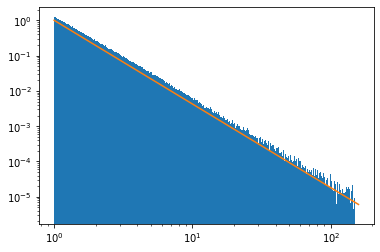

In [30]:
print(MLE_with_std(masses_LMC[masses_LMC>1]))
print(MLE_with_std(masses_LMC[masses_LMC>15]))

logbins=np.logspace(0,2.2,int(2*len(masses_LMC)**(2/5)+1))

plt.hist(masses_LMC, bins=logbins, range=(0,150), density=True)
plt.xscale('log')
plt.yscale('log')

def Normalization_powerlaw(data, alpha):
    return (1-alpha)/(max(data)**(1-alpha)-min(data)**(1-alpha))

plt.plot(logbins, logbins**(-2.372), label='Power law with alpha=2.3')

### Alternative: Do simulation without random drawing and just mathematically simulate the functional form

In the case of random sampling the intrinsic mmax-Mecl relation vanishes and the upper integration bound becomes simply the theoretical upper limit for all clusters. (Or one should probably distinguish, when the cluster masses becomes smaller than the upper limit. Then the upper limit becomes simply the mass of the cluster?!)

$\xi_{IGIMF}(m)= \sum_{i=1}^{N} \int_{m_{min}}^{m_{max}(M_{ecl})} k_i \xi_i(m,\alpha_i) dm$

with $m_{max}(M_{ecl})=\begin{cases} m_{max}=150.0 M_{\odot}, \quad M_{ecl}>150.0 M_{\odot},\\ m_{max}=M_{ecl}, \quad M_{ecl}< 150.0 M_{\odot}  \end{cases}$.

The normalization constants $k_i$ can simply be calculated by the known masses of the clusters $M_{ecl,i}$ since

$M_{ecl,i}=\int^{m_{max}}_{m_{min}} k_i \xi_i(m,\alpha_i) m dm$
$\Rightarrow k_i =\frac{M_{ecl,i}}{\int^{m_{max}}_{m_{min}} \xi_i(m,\alpha_i)m dm}$

In [1]:
### Define a stellar varying IMF function


import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.optimize import root_scalar

## define the mmax function

def mmax_func(M_ecl):
    if M_ecl>=150.0+0.72: ## add 9 stars with 0.08 so a cluster consists of at least 10 stars
        return 150.0
    else:
        return M_ecl -0.72 ## mass of most massive stars can be this at mass

def function_alpha_1_change(alpha1_model, M_over_H):
    alpha_1 = 1.3
    if (alpha1_model == 0):
        return alpha_1
    elif (alpha1_model == 1):
        alpha_1_change = alpha_1 + 0.5 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'IGIMF2.5'):
        alpha_1_change = alpha_1 + 0.12 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'Z_MW'):
        alpha_1_change = alpha_1 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        return alpha_1_change
    elif (alpha1_model == 'Z'):
        alpha_1_change = alpha_1 + 63 * (10**M_over_H - 1) * 0.0142
        return alpha_1_change
    else:
        print('Invalid Input for alpha1 model')
        return

## Function to change alpha_2 depending on the model; imported from galimf.py
def function_alpha_2_change(alpha2_model, M_over_H):
    alpha_2=2.3
    if (alpha2_model == 0):
        return alpha_2
    elif (alpha2_model == 1):
        alpha_2_change = alpha_2 + 0.5 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'Z_MW'):
        alpha_2_change = alpha_2 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'Z'):
        alpha_2_change = alpha_2 + 63 * (10**M_over_H - 1) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'IGIMF2.5'):
        alpha_2_change = alpha_2 + 0.12 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'R14'):
        alpha_2_change = 2.3 + 0.0572 * M_over_H
        return alpha_2_change
    else:
        print('Invalid input for alpha2 model')
        return

def function_alpha_3_change(alpha3_model, M_ecl, M_over_H):
    ## M_ecl is the mass of the cluster
    ## M_over_H is the metallicity of the cluster, but apparently is in reality [Z]
    ## since the formula for model 2 is similar to the formula from Yan et al.(2021)
    ## where [Z] is used, I assume that M_over_H is actually [Z]
    ## alpha3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
    if (alpha3_model == 0):
        default_alpha3 = 2.3
        # print("alpha_3 is set to be a constant: %s, as this is the default alpha_3 value for alpha3_model 0.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (default_alpha3))
        return default_alpha3
    elif (alpha3_model == 1):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        if rho < 9.5 * 10 ** 4:
            alpha_3_change = 2.3
        else:
            alpha_3_change = 1.86 - 0.43 * math.log(rho / 10 ** 6, 10)
        # print("Notification in file 'alpha3_model' uncompleted")
        if alpha_3_change < 0.5:
            print("IMF alpha_3 being", alpha_3_change, "out of the tested range from Marks et al. 2012.")
        return alpha_3_change
    elif (alpha3_model == 2):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        x = -0.14 * M_over_H + 0.99 * math.log(rho / 10 ** 6, 10)
        if x < -0.87:
            alpha_3_change = 2.3
        else:
            alpha_3_change = -0.41 * x + 1.94
        # print("Notification in file 'alpha3_model' uncompleted")
        return alpha_3_change
    elif (alpha3_model == 'R14'):
        alpha_3_change = 2.3 + 0.0572 * M_over_H
        return alpha_3_change
    else:
        # print("alpha_3 is set to be a constant: %s, as this is the input value of parameter 'alpha3_model'.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (alpha3_model))
        return alpha3_model
    
#### This function serves to calculate the normlaization constant by calculating the varying IMF

def normalization_constant(M_ecl):

    ## first define a varying IMF function

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=mmax_func(M_ecl)

    ## Varying IMF model for metallicity like in LMC
    alpha_1_model='Z'
    alpha_2_model='Z'
    Metallicity=-0.37
    alpha_3_model=2


    ## Calculation of the IMF exponents
    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

    ## Calculation of the IMF normalization constants k1, k2 and k3
    Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
    Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
    Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

    k_1 = 1/(Term_1+Term_2+Term_3)
    k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

    def IMF(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return k_1*x**(-alpha_1)
        if m_1<=x<m_2:
            return k_2*x**(-alpha_2)
        if m_2<=x<=m_max:
            return k_3*x**(-alpha_3)
        if x>m_max:
            return 0
        
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    #normalization_constant=M_ecl/quad(IMF, m_0, m_max, limit=10000)[0] (?)
    normalization_constant=1/quad(IMF, m_0, m_max, limit=10000)[0]
    return normalization_constant

def normalization_constant_newtry(M_ecl):

    ## first define a varying IMF function

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=mmax_func(M_ecl)

    ## Varying IMF model for metallicity like in LMC
    alpha_1_model='Z'
    alpha_2_model='Z'
    Metallicity=-0.37
    alpha_3_model=2


    ## Calculation of the IMF exponents
    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

    ## Calculation of the IMF normalization constants k1, k2 and k3
    ### THIS PART WOULD NORMALIZE THE IMF TO 1, BUT I DONT WANT THIS
    #Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
    #Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
    #Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

    #k_1 = 1/(Term_1+Term_2+Term_3)
    #k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

    def IMF_m(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return x**(1-alpha_1)
        if m_1<=x<m_2:
            return x**(1-alpha_2)*m_1**(alpha_2-alpha_1)
        if m_2<=x<=m_max:
            return x**(1-alpha_3)*m_1**(alpha_2-alpha_1)
        if x>m_max:
            return 0
        
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    #normalization_constant=M_ecl/quad(IMF, m_0, m_max, limit=10000)[0] (?)
    normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]
    return normalization_constant

## Define the IGIMF function as a sum of varying IMFs
## This function is the IGIMF that comes out, when the stellar IMF is randomly sampled

def IGIMF_random_sampling(M_ecl_array, m_array):

    ### define the IMF again as a function
    def IMF_func(m, M_ecl):

        ## first define a varying IMF function

        ## Parameters given by Theory
        M_turn=0.5
        M_turn2=1.0

        m_0=0.08
        m_1=0.5
        m_2=1.0
        m_max=mmax_func(M_ecl)

        ## Varying IMF model for metallicity like in LMC
        alpha_1_model='Z'
        alpha_2_model='Z'
        Metallicity=-0.37
        alpha_3_model=2


        ## Calculation of the IMF exponents
        alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
        alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
        alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

        ## Calculation of the IMF normalization constants k1, k2 and k3
        Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
        Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
        Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

        k_1 = 1/(Term_1+Term_2+Term_3)
        k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

        def IMF(x):
            if x<m_0:
                return 0
            if m_0<=x<m_1:
                return k_1*x**(-alpha_1)
            if m_1<=x<m_2:
                return k_2*x**(-alpha_2)
            if m_2<=x<=m_max:
                return k_3*x**(-alpha_3)
            if x>m_max:
                return 0
        
        return IMF(m)
    
    ## Define the IGIMF as a sum of IMFs
    IGIMF_array=np.array([])
    def IGIMF_func(m, M_ecl_array):
        IGIMF=0
        for i in range(len(M_ecl_array)):
            IGIMF+=normalization_constant_newtry(M_ecl_array[i])*IMF_func(m, M_ecl_array[i])
        return IGIMF
    
    ## Calculate the IGIMF for each mass in the mass array
    for i in range(len(m_array)):
        IGIMF_array=np.append(IGIMF_array, IGIMF_func(m_array[i], M_ecl_array))
        print(m_array[i])
    
    return IGIMF_array

In [ ]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_2_PL.txt')

IGIMF_array=IGIMF_random_sampling(M_ecl_array, m_input_array)

0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11577841156594865
0.1166

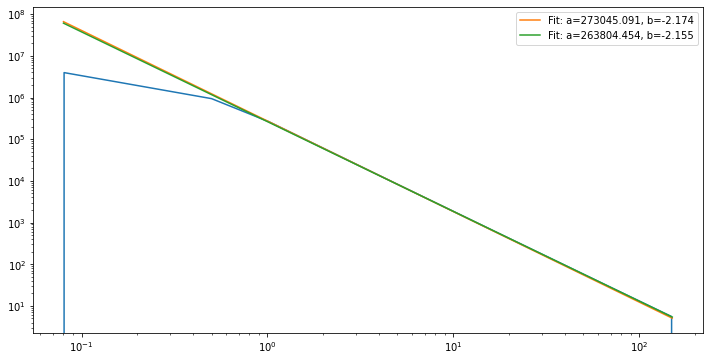

In [12]:
plt.figure(figsize=(12,6))

plt.plot(m_input_array, IGIMF_array)
plt.xscale('log')
plt.yscale('log')

## make a fit on the IGIMF for m>1 Msolar

def fit_function(x, a, b):
    return a*x**b

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>1], IGIMF_array[m_input_array>1])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>15], IGIMF_array[m_input_array>15])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

plt.legend()

### The code works!!! The only improvement that could be made is maybe for the fit function, bc this usually values the parts with low values less strongly and wouldn't catch a downturn. So I could transform the IGIMF data by appyling a log to it to reduce this effect. 
### The code could easily be also made for an optimally sampled IGIMF by replacing the mmax_func function by something that uses the mmax-Mecl relation.

In [2]:
## Find m_max for a given M_ecl; m_max is the upper integration limit for the most massive star in the cluster
## m_max is NOT the mass of the most massive star in the cluster!

## Make finding m_max into a function
## M_ecl is the mass of the cluster 
#(in supplementary document is called M_tot, but I use M_tot later for the total mass of the region to avoid confusion)
## alpha_3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
## M_over_H is the metallicity of the cluster

### This function serves to find the most massive stellar mass of an optimally sampled IMF
### dependent on the cluster mass and metallicity

def find_m_max_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):
    M_str_L = 0.08  # star mass lower limit [solar mass]
    M_str_U = 150.0  # star mass upper limit [solar mass]
    M_turn = 0.5  # IMF power-index breaking mass [solar mass]
    M_turn2 = 1.0  # IMF power-index breaking mass [solar mass]

    I = 1.0 ## I=I_str

    alpha_1 = function_alpha_1_change(alpha_1_model, M_over_H)  # IMF power-index for M_str_L < M < M_turn
    alpha_2 = function_alpha_2_change(alpha_2_model, M_over_H)  # IMF power-index for M_turn < M < M_turn2
    alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, M_over_H)  # IMF power-index for M_turn2 < M < M_str_U

    def Max(M_max):
        eq1 = M_ecl * M_str_U**(1-alpha_3) / (I * (1-alpha_3)) - M_turn2**(alpha_2-alpha_3) * M_turn**(alpha_1-alpha_2) / (2-alpha_1) * (M_turn**(2-alpha_1) - M_str_L**(2-alpha_1)) - M_turn2**(alpha_2-alpha_3) / (2-alpha_2) * (M_turn2**(2-alpha_2) - M_turn**(2-alpha_2)) + M_turn2**(2-alpha_3) / (2-alpha_3)
        eq2 = M_max**(2-alpha_3) / (2-alpha_3) + M_ecl * M_max**(1-alpha_3) / (I * (1-alpha_3))
        return eq1 - eq2
    
    sol = root_scalar(Max, bracket=[M_str_L, 0.9999*M_str_U])
    M_max = sol.root

    def model_IMF_m(m, alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3):
        M_str_L = 0.08  # star mass lower limit [solar mass]
        M_str_U = 150.0  # star mass upper limit [solar mass]
        M_turn = 0.5  # IMF power-index breaking mass [solar mass]
        M_turn2 = 1.  # IMF power-index breaking mass [solar mass]

        alpha_1 = function_alpha_1_change(alpha_1_model, M_over_H)  # IMF power-index for M_str_L < M < M_turn
        alpha_2 = function_alpha_2_change(alpha_2_model, M_over_H)  # IMF power-index for M_turn < M < M_turn2
        alpha_3 = function_alpha_3_change(alpha_3_model, M_ecl, M_over_H) #IMF power-index for M_turn2 < M < M_str_U

        ## distinction between cases; IMF is three-part power-law
        if m < M_str_L:
            return 0
        if M_str_L < m < M_turn:
            ### becomes relevant when M_turn and M_turn_2 take different values
            #k1 = M_turn2**(alpha_2-alpha_3) * M_turn**(alpha_1-alpha_2)*k3 
            ### When M_turn=0.5 and M_turn2=1.0, k1 simplifies to:
            ###k1= 2.0*k3 ## No! This is only correct, when alpha_1=1.3, alpha_2=2.3 and alpha_3=2.3
            k1=M_turn**(alpha_1-alpha_2)*k3

            return k1 * m**(1-alpha_1)
        if M_turn < m < M_turn2:
            ### becomes relevant when M_turn and M_turn_2 take different values
            #k2 = M_turn2**(alpha_2-alpha_3)*k3 
            ### When M_turn=0.5 and M_turn2=1.0, k2 simplifies to:
            k2= 1.0*k3 ## k2=k3
            return k2 * m**(1-alpha_2)
        if M_turn2 < m < M_str_U:
            return k3*m**(1-alpha_3) ##
        if m > M_str_U:
            return 0

    ### if M_turn2 < m_max < M_str_U: (which is always the case)
    k3= I*(1-alpha_3)/(M_str_U**(1-alpha_3)-M_max**(1-alpha_3))
    k1=M_turn**(alpha_1-alpha_2)*k3
    k2=k3 ## This is only true, if M_turn2=1.0

    ## can either be case 1 or 2
    m_i_1=(M_max**(1-alpha_3)-(1-alpha_3)/(k3))**(1/(1-alpha_3)) #Case 1
    #m_i_2=(M_turn2**(1-alpha_2)+k3/k2*(1-alpha_2)/(1-alpha_3)*(m_i**(1-alpha_3)-M_turn2**(1-alpha_3))-(1-alpha_2)/k2)**(1/(1-alpha_2)) #Case 2
    #if M_turn2 < m_i_1 < m_i < M_str_U:
    #counter1=counter1+1
    #m_i_array=np.append(m_i_array,m_i_1)
    ### with calculated m_i+1, the mass M_i can be determined by integrating the IMF from m_i+1 to m_i
    M_i= (scipy.integrate.quad(model_IMF_m, m_i_1, M_max, args=(alpha_1_model, alpha_2_model, alpha_3_model, M_ecl, M_over_H, k3))[0])
    #M_i_array=np.append(M_i_array,M_i)

    return M_i

## Do I need to calculate the maximum stellar mass then too or just use the integration limit?
## I think I need to calculate the maximum stellar mass for the cluster bc this calculation
## only gives me the integration limit for the most massive star in the cluster
## For the random sampling there I do not need to calculate the upper integration limit,
## bc there is not the same dependence of it on the cluster mass

In [3]:
def function_alpha_1_change(alpha1_model, M_over_H):
    alpha_1 = 1.3
    if (alpha1_model == 0):
        return alpha_1
    elif (alpha1_model == 1):
        alpha_1_change = alpha_1 + 0.5 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'IGIMF2.5'):
        alpha_1_change = alpha_1 + 0.12 * M_over_H
        return alpha_1_change
    elif (alpha1_model == 'Z_MW'):
        alpha_1_change = alpha_1 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        return alpha_1_change
    elif (alpha1_model == 'Z'):
        alpha_1_change = alpha_1 + 63 * (10**M_over_H - 1) * 0.0142
        return alpha_1_change
    else:
        print('Invalid Input for alpha1 model')
        return

## Function to change alpha_2 depending on the model; imported from galimf.py
def function_alpha_2_change(alpha2_model, M_over_H):
    alpha_2=2.3
    if (alpha2_model == 0):
        return alpha_2
    elif (alpha2_model == 1):
        alpha_2_change = alpha_2 + 0.5 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'Z_MW'):
        alpha_2_change = alpha_2 + 79.4 * (10**M_over_H - 10**(-0.1)) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'Z'):
        alpha_2_change = alpha_2 + 63 * (10**M_over_H - 1) * 0.0142
        if M_over_H>1:
            print("Warning: Abnormally high gas metallicity leading to an unrealistic IMF shape according to the assumed variation law: alpha2_model == 'Z'. Please check your galaxy evolution settings or change to a different IMF variation assumption.")
        return alpha_2_change
    elif (alpha2_model == 'IGIMF2.5'):
        alpha_2_change = alpha_2 + 0.12 * M_over_H
        return alpha_2_change
    elif (alpha2_model == 'R14'):
        alpha_2_change = 2.3 + 0.0572 * M_over_H
        return alpha_2_change
    else:
        print('Invalid input for alpha2 model')
        return

def function_alpha_3_change(alpha3_model, M_ecl, M_over_H):
    ## M_ecl is the mass of the cluster
    ## M_over_H is the metallicity of the cluster, but apparently is in reality [Z]
    ## since the formula for model 2 is similar to the formula from Yan et al.(2021)
    ## where [Z] is used, I assume that M_over_H is actually [Z]
    ## alpha3_model is the model for the IMF power-index for M_turn2 < M < M_str_U
    if (alpha3_model == 0):
        default_alpha3 = 2.3
        # print("alpha_3 is set to be a constant: %s, as this is the default alpha_3 value for alpha3_model 0.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (default_alpha3))
        return default_alpha3
    elif (alpha3_model == 1):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        if rho < 9.5 * 10 ** 4:
            alpha_3_change = 2.3
        else:
            alpha_3_change = 1.86 - 0.43 * math.log(rho / 10 ** 6, 10)
        # print("Notification in file 'alpha3_model' uncompleted")
        if alpha_3_change < 0.5:
            print("IMF alpha_3 being", alpha_3_change, "out of the tested range from Marks et al. 2012.")
        return alpha_3_change
    elif (alpha3_model == 2):
        rho = 10 ** (0.61 * math.log(M_ecl, 10) + 2.85)
        x = -0.14 * M_over_H + 0.99 * math.log(rho / 10 ** 6, 10)
        if x < -0.87:
            alpha_3_change = 2.3
        else:
            alpha_3_change = -0.41 * x + 1.94
        # print("Notification in file 'alpha3_model' uncompleted")
        return alpha_3_change
    elif (alpha3_model == 'R14'):
        alpha_3_change = 2.3 + 0.0572 * M_over_H
        return alpha_3_change
    else:
        # print("alpha_3 is set to be a constant: %s, as this is the input value of parameter 'alpha3_model'.\nFor more options regarding alpha_3 variation, please check file 'alpha3.py'" % (alpha3_model))
        return alpha3_model
    
#### This function serves to calculate the normalization constant by calculating the varying IMF
#### for an optimally sampled IMF

def normalization_constant_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):

    ## first define a varying IMF function

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=find_m_max_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)

    ## Varying IMF model for metallicity like in LMC
    alpha_1_model='Z'
    alpha_2_model='Z'
    Metallicity=-0.37
    alpha_3_model=2


    ## Calculation of the IMF exponents
    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

    ## Calculation of the IMF normalization constants k1, k2 and k3
    Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
    Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
    Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

    k_1 = 1/(Term_1+Term_2+Term_3)
    k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

    def IMF(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return k_1*x**(-alpha_1)
        if m_1<=x<m_2:
            return k_2*x**(-alpha_2)
        if m_2<=x<=m_max:
            return k_3*x**(-alpha_3)
        if x>m_max:
            return 0
        
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    ## increase the exactness of the integration by increasing the limit of the recursion depth
    #normalization_constant=M_ecl/quad(IMF, m_0, m_max)[0] (?)
    normalization_constant=1/quad(IMF, m_0, m_max, limit=10000)[0]
    return normalization_constant

def normalization_constant_optimal_newtry(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H):
    
    ## first define a varying IMF function

    ## Parameters given by Theory
    M_turn=0.5
    M_turn2=1.0

    m_0=0.08
    m_1=0.5
    m_2=1.0
    m_max=find_m_max_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, M_over_H)

    ## Varying IMF model for metallicity like in LMC
    alpha_1_model='Z'
    alpha_2_model='Z'
    Metallicity=-0.37
    alpha_3_model=2


    ## Calculation of the IMF exponents
    alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
    alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
    alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

    ## Calculation of the IMF normalization constants k1, k2 and k3
    ### THIS PART WOULD NORMALIZE THE IMF TO 1, BUT I DONT WANT THIS
    #Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
    #Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
    #Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

    #k_1 = 1/(Term_1+Term_2+Term_3)
    #k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

    def IMF_m(x):
        if x<m_0:
            return 0
        if m_0<=x<m_1:
            return x**(1-alpha_1)
        if m_1<=x<m_2:
            return x**(1-alpha_2)*m_1**(alpha_2-alpha_1)
        if m_2<=x<=m_max:
            return x**(1-alpha_3)*m_1**(alpha_2-alpha_1)
        if x>m_max:
            return 0
    
    ## Calculate the normalization constant by integrating the IMF over the mass range
    #normalization_constant=M_ecl/quad(IMF, m_0, m_max, limit=10000)[0] (?)
    normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]

    return normalization_constant

## Define the IGIMF function as a sum of varying IMFs
## This function is the IGIMF that comes out, when the stellar IMF is optimally sampled

def IGIMF_optimal_sampling(M_ecl_array, m_array):

    ### define the IMF again as a function
    def IMF_func(m, M_ecl):

        ## first define a varying IMF function

        ## Parameters given by Theory
        M_turn=0.5
        M_turn2=1.0

        m_0=0.08
        m_1=0.5
        m_2=1.0
        #m_max=mmax_func(M_ecl)

        ## Varying IMF model for metallicity like in LMC
        alpha_1_model='Z'
        alpha_2_model='Z'
        Metallicity=-0.37
        alpha_3_model=2


        ## Calculation of the IMF exponents
        alpha_1=function_alpha_1_change(alpha_1_model, Metallicity)
        alpha_2=function_alpha_2_change(alpha_2_model, Metallicity)
        alpha_3=function_alpha_3_change(alpha_3_model, M_ecl, Metallicity)

        m_max=find_m_max_optimal(M_ecl, alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)

        ## Calculation of the IMF normalization constants k1, k2 and k3
        Term_1=1/(1-alpha_1)*(m_1**(1-alpha_1)-m_0**(1-alpha_1))
        Term_2=0.5*1/(1-alpha_2)*(m_2**(1-alpha_2)-m_1**(1-alpha_2))
        Term_3=0.5*1/(1-alpha_3)*(m_max**(1-alpha_3)-m_2**(1-alpha_3))

        k_1 = 1/(Term_1+Term_2+Term_3)
        k_2 = k_3 = k_1*m_1**(alpha_2-alpha_1)

        def IMF(x):
            if x<m_0:
                return 0
            if m_0<=x<m_1:
                return k_1*x**(-alpha_1)
            if m_1<=x<m_2:
                return k_2*x**(-alpha_2)
            if m_2<=x<=m_max:
                return k_3*x**(-alpha_3)
            if x>m_max:
                return 0
        
        return IMF(m)
    
    ## Varying IMF model for metallicity like in LMC
    alpha_1_model='Z'
    alpha_2_model='Z'
    Metallicity=-0.37
    alpha_3_model=2
    
    ## Define the IGIMF as a sum of IMFs
    IGIMF_array=np.array([])
    def IGIMF_func(m, M_ecl_array):
        IGIMF=0
        for i in range(len(M_ecl_array)):
            IGIMF+=normalization_constant_optimal_newtry(M_ecl_array[i], alpha_1_model, alpha_2_model, alpha_3_model, Metallicity)*IMF_func(m, M_ecl_array[i])
        return IGIMF
    
    ## Calculate the IGIMF for each mass in the mass array
    for i in range(len(m_array)):
        IGIMF_array=np.append(IGIMF_array, IGIMF_func(m_array[i], M_ecl_array))
        print(m_array[i])
    
    return IGIMF_array

In [26]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_2_PL.txt')

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random=IGIMF_random_sampling(M_ecl_array, m_input_array)
IGIMF_array_optimal=IGIMF_optimal_sampling(M_ecl_array, m_input_array)

0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11577841156594865
0.1166

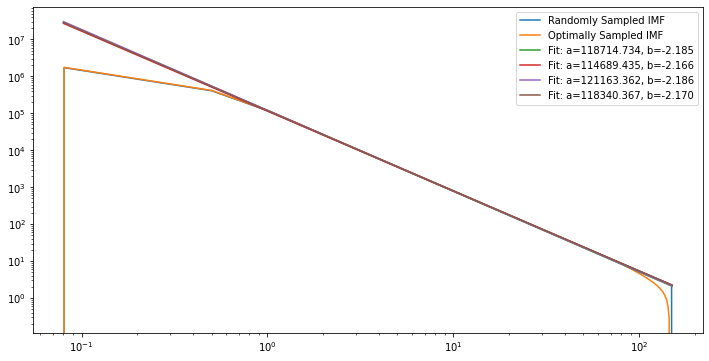

In [71]:
plt.figure(figsize=(12,6))

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)

plt.plot(m_input_array, IGIMF_array_random, label='Randomly Sampled IMF')
plt.plot(m_input_array, IGIMF_array_optimal, label='Optimally Sampled IMF')
plt.xscale('log')
plt.yscale('log')

## make a fit on the IGIMF for m>1 Msolar

def fit_function(x, a, b):
    return a*x**b

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>1], IGIMF_array_random[m_input_array>1])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>15], IGIMF_array_random[m_input_array>15])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>1], IGIMF_array_optimal[m_input_array>1])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>15], IGIMF_array_optimal[m_input_array>15])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

#plt.xlim(15,150)
#plt.ylim(1,1e3)
plt.legend()

When only using the most massive clusters, the slopes of the random and optimal IGIMF are similar, bc the at the point where they become similar the effect of the mmax mecl relation has not appeared yet, due to the sample being cut off. Therefore significant differences should be expected either for large beta with small M1 and for the galaxy-wide samples.

In [30]:
### repeat for all LMC clusters

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 200)
M_ecl_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_2_PL_all_1SM_stars.txt')

print(M_ecl_array[2300])
num_stars_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_2_PL_all_1SM_stars_num_stars_array.txt')

print(num_stars_array[2300])
print(num_stars_array[26704], num_stars_array[26705], num_stars_array[26706])
## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_LMC=IGIMF_random_sampling(M_ecl_array[:2300], m_input_array)
IGIMF_array_optimal_LMC=IGIMF_optimal_sampling(M_ecl_array[:2300], m_input_array)

186.9297894196479
10.0
1.0 0.0 0.0
0.07999999999999999
0.08308779420305992
0.08629476931912552
0.0896255254248504
0.09308484014801356
0.09667767552053606
0.10040918509600633
0.1042847213419241
0.10830984331726554
0.11249032464638284
0.11683216180067575
0.12134158269991434
0.12602505564555078
0.13088929859883378
0.1359412888170345
0.14118827286160623
0.14663777699263264
0.15229761796447577
0.15817591423810762
0.16428109762620927
0.17062192538774096
0.17720749278933087
0.1840472461515019
0.19115099639844882
0.19852893313080214
0.20619163924156422
0.21415010609618335
0.22241574929853916
0.23100042506545496
0.23991644723322367
0.2491766049205422
0.2587941808731898
0.26878297051676336
0.2791573017447995
0.2899320554706677
0.3011226869727124
0.3127452480632646
0.3248164101133183
0.3373534879659013
0.3503744647724409
0.36389801778774805
0.3779435451606233
0.3925311937585095
0.407681888066106
0.42341736019939424
0.4397601810781272
0.4567337928014975
0.4743625422734231
0.49267171612568134
0.511

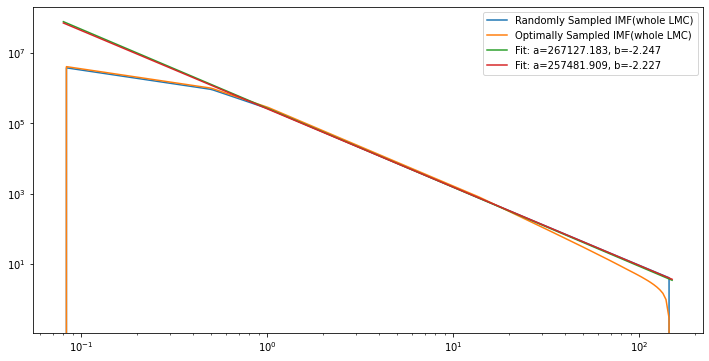

In [31]:
plt.figure(figsize=(12,6))

plt.plot(m_input_array, IGIMF_array_random_LMC, label='Randomly Sampled IMF(whole LMC)')
plt.plot(m_input_array, IGIMF_array_optimal_LMC, label='Optimally Sampled IMF(whole LMC)')
plt.xscale('log')
plt.yscale('log')

## make a fit on the IGIMF for m>1 Msolar

def fit_function(x, a, b):
    return a*x**b

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>1], IGIMF_array_random_LMC[m_input_array>1])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>15], IGIMF_array_random_LMC[m_input_array>15])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))
#plt.xlim(15,150)
#plt.ylim(1,1e3)
plt.legend()

A clear difference is evident. 

But keep in mind, that the random sampling function in NOT correct just yet. There is something wrong when the normalization constant for the random case when the cluster mass gets smaller than 150 solar masses. The very steep IMFs of the low-mass clusters are currently!!

Are the normalization constants correct?!
The normalization is currently Mecl/int(IMF), I think it should be 1/int(IMF) instead. I corrected it to be Mecl/int(IMF*m)

In [32]:
### Test the normalization constant function
M_ecl_test=1000

print(normalization_constant(M_ecl_test))
print(normalization_constant_newtry(M_ecl_test))

0.9999999991514306
516.7178268530618


In [33]:
### repeat for all LMC clusters

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)
M_ecl_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_2_PL_all_1SM_stars.txt')

print(M_ecl_array[2300])
num_stars_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_2_PL_all_1SM_stars_num_stars_array.txt')

print(num_stars_array[2300])
print(num_stars_array[26704], num_stars_array[26705], num_stars_array[26706])
## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_LMC_new=IGIMF_random_sampling(M_ecl_array, m_input_array)
IGIMF_array_optimal_LMC_new=IGIMF_optimal_sampling(M_ecl_array, m_input_array)

186.9297894196479
10.0
1.0 0.0 0.0


<ipython-input-24-e9f34a4a4e5e>:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.19027

<ipython-input-25-1cec3dc015ee>:188: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.19027

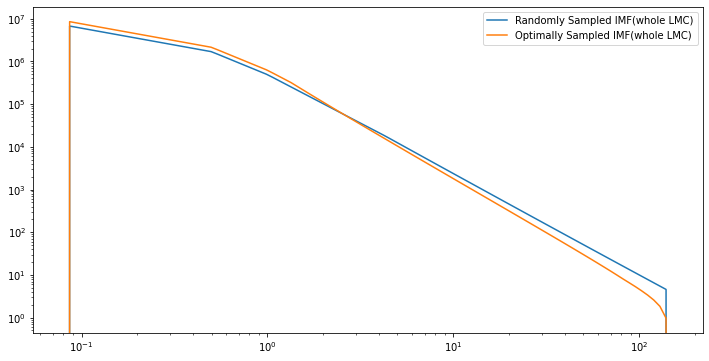

In [39]:
plt.figure(figsize=(12,6))

plt.plot(m_input_array, IGIMF_array_random_LMC_new, label='Randomly Sampled IMF(whole LMC)')
plt.plot(m_input_array, IGIMF_array_optimal_LMC_new, label='Optimally Sampled IMF(whole LMC)')
plt.xscale('log')
plt.yscale('log')

## make a fit on the IGIMF for m>1 Msolar

def fit_function(x, a, b):
    return a*x**b

#popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>1], IGIMF_array_random_LMC_new[m_input_array>1])
#plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

#popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>15], IGIMF_array_random_LMC_new[m_input_array>15])
#plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))
#plt.xlim(15,150)
#plt.ylim(1,1e3)
plt.legend()

In [36]:
### save the data arrays in txt files (2 arrays in 1 file)

#np.savetxt('IGIMF_array_random_LMC_M1_5e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_random_LMC_new]))
#np.savetxt('IGIMF_array_optimal_LMC_M1_5e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_optimal_LMC_new]))

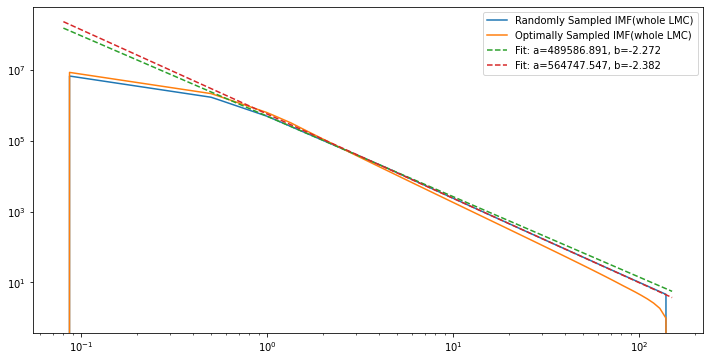

In [44]:
plt.figure(figsize=(12,6))

plt.plot(m_input_array, IGIMF_array_random_LMC_new, label='Randomly Sampled IMF(whole LMC)')
plt.plot(m_input_array, IGIMF_array_optimal_LMC_new, label='Optimally Sampled IMF(whole LMC)')
plt.xscale('log')
plt.yscale('log')

## make a fit on the IGIMF for m>1 Msolar

def fit_function(x, a, b):
    return a*x**b

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>1], IGIMF_array_random_LMC_new[m_input_array>1])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>15], IGIMF_array_random_LMC_new[m_input_array>15])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')
#plt.xlim(1,150)
#plt.ylim(1,1e3)
plt.legend()

[ 5.72416325 -2.36092224]
[0.0030341  0.00242754]
[ 5.73440264 -2.36916359]
[0.00164865 0.00097664]
[ 5.83123653 -2.58464075]
[0.01149119 0.00919395]
[ 6.03194169 -2.70158729]
[0.06247279 0.03700815]


<ipython-input-73-5f4ab69e1b10>:45: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_random_LMC_new) , label='Randomly Sampled IMF(whole LMC)')
<ipython-input-73-5f4ab69e1b10>:46: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_optimal_LMC_new) ,label='Optimally Sampled IMF(whole LMC)')


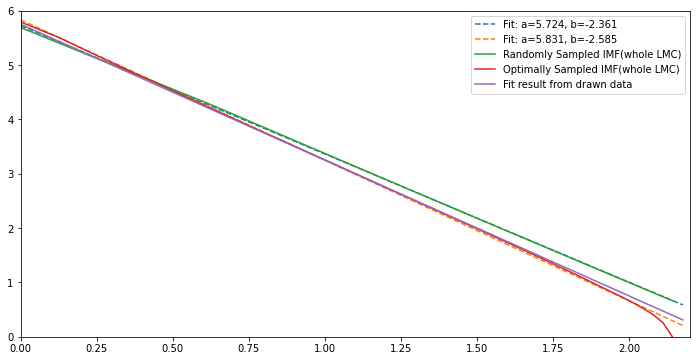

In [73]:
## make fit for the logarithmic data

def fit_function(x, a, b):
    return a+x*b

plt.figure(figsize=(12,6))

data_random=np.loadtxt('IGIMF_array_random_LMC_M1_5e4_beta_2_PL.txt')
data_optimal=np.loadtxt('IGIMF_array_optimal_LMC_M1_5e4_beta_2_PL.txt')

m_input_array=data_random[0]
IGIMF_array_random_LMC_new=data_random[1]
IGIMF_array_optimal_LMC_new=data_optimal[1]

IGIMF_array_random_LMC_new_cut=IGIMF_array_random_LMC_new[IGIMF_array_random_LMC_new>1]
m_input_array_cut=m_input_array[IGIMF_array_random_LMC_new>1]
IGIMF_array_optimal_LMC_new_cut=IGIMF_array_optimal_LMC_new[IGIMF_array_random_LMC_new>1]

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>1]), np.log10(IGIMF_array_random_LMC_new_cut[m_input_array_cut>1]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>15]), np.log10(IGIMF_array_random_LMC_new_cut[m_input_array_cut>15]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>1]), np.log10(IGIMF_array_optimal_LMC_new_cut[m_input_array_cut>1]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>15]), np.log10(IGIMF_array_optimal_LMC_new_cut[m_input_array_cut>15]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

#plt.figure(figsize=(12,6))

plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_random_LMC_new) , label='Randomly Sampled IMF(whole LMC)')
plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_optimal_LMC_new) ,label='Optimally Sampled IMF(whole LMC)')
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

plt.xlim(0,2.2)
plt.ylim(0,6)

plt.plot(np.log10(m_input_array), 5.75+np.log10(m_input_array**(-2.5)), label='Fit result from drawn data')

plt.legend()

There are some deviations from the results to when I actually draw all stellar masses for the optimal sampling case. Is this difference due to an error in my modelling or due to something else?
Randomness coming in for drawn sample(There are some features that occur; uncertainties for each cluster adding up?)? Still an error with the normalization? Too few data points?!

From the fit to the clusters only in 30Dor I would suspect that the model works as intended, but for the whole LMC there seems to be some deviation, for which I currently don't know where it stems from...

I did not cut R136 from the sample!

In [18]:
## repeat for all LMC clusters (beta=1.5) to test the maximum for spatial randomness!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 200)
M_ecl_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_1_5_PL.txt')

## exclude R136
M_ecl_array_cut=M_ecl_array[1:]

print(M_ecl_array[2300])
num_stars_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_1_5_PL_num_stars_array.txt')

print(num_stars_array[2300])
#print(num_stars_array[26704], num_stars_array[26705], num_stars_array[26706])
## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_LMC_beta_1_5=IGIMF_random_sampling(M_ecl_array_cut, m_input_array)
#IGIMF_array_optimal_LMC_new=IGIMF_optimal_sampling(M_ecl_array, m_input_array)

56.90525726756388
333.0


<ipython-input-1-e9f34a4a4e5e>:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08308779420305992
0.08629476931912552
0.0896255254248504
0.09308484014801356
0.09667767552053606
0.10040918509600633
0.1042847213419241
0.10830984331726554
0.11249032464638284
0.11683216180067575
0.12134158269991434
0.12602505564555078
0.13088929859883378
0.1359412888170345
0.14118827286160623
0.14663777699263264
0.15229761796447577
0.15817591423810762
0.16428109762620927
0.17062192538774096
0.17720749278933087
0.1840472461515019
0.19115099639844882
0.19852893313080214
0.20619163924156422
0.21415010609618335
0.22241574929853916
0.23100042506545496
0.23991644723322367
0.2491766049205422
0.2587941808731898
0.26878297051676336
0.2791573017447995
0.2899320554706677
0.3011226869727124
0.3127452480632646
0.3248164101133183
0.3373534879659013
0.3503744647724409
0.36389801778774805
0.3779435451606233
0.3925311937585095
0.407681888066106
0.42341736019939424
0.4397601810781272
0.4567337928014975
0.4743625422734231
0.49267171612568134
0.5116875769889873
0.5314374011640421
0.

In [19]:
print(len(M_ecl_array), len(M_ecl_array[1:]))
#np.savetxt('IGIMF_array_random_LMC_withoutR136_M1_5e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_random_LMC_beta_1_5]))

7950 7949


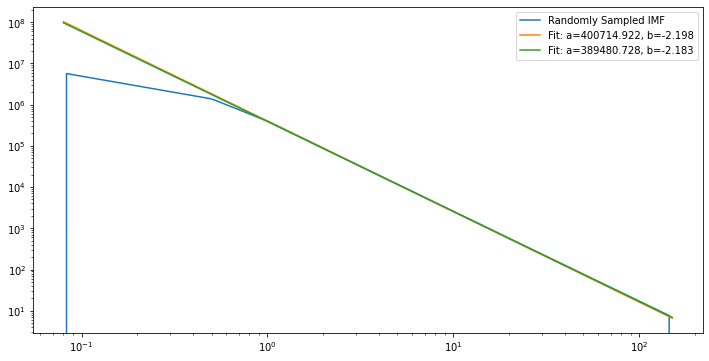

In [20]:
plt.figure(figsize=(12,6))

#m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)

plt.plot(m_input_array, IGIMF_array_random_LMC_beta_1_5, label='Randomly Sampled IMF')
#plt.plot(m_input_array, IGIMF_array_optimal, label='Optimally Sampled IMF')
plt.xscale('log')
plt.yscale('log')

## make a fit on the IGIMF for m>1 Msolar

def fit_function(x, a, b):
    return a*x**b

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>1], IGIMF_array_random_LMC_beta_1_5[m_input_array>1])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

popt, pcov = curve_fit(fit_function, m_input_array[m_input_array>15], IGIMF_array_random_LMC_beta_1_5[m_input_array>15])
plt.plot(m_input_array, fit_function(m_input_array, *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt))

#plt.xlim(1,150)
#plt.ylim(1,1e3)
plt.legend()

[ 5.59799759 -2.18689138]
[0.00042144 0.00033696]
[ 5.58355411 -2.17815422]
[0.00042718 0.00025151]


<ipython-input-21-da03549a6eb7>:36: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_random_LMC_beta_1_5) , label='Randomly Sampled IMF(whole LMC)')


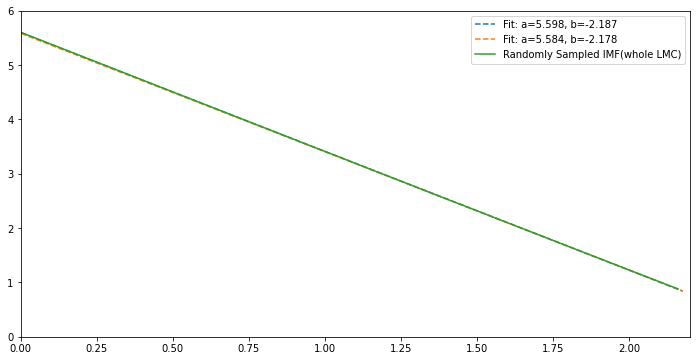

In [21]:
## make fit for the logarithmic data

def fit_function(x, a, b):
    return a+x*b

plt.figure(figsize=(12,6))

#data_random=np.loadtxt('IGIMF_array_random_LMC_M1_5e4_beta_2_PL.txt')
#data_optimal=np.loadtxt('IGIMF_array_optimal_LMC_M1_5e4_beta_2_PL.txt')

#m_input_array=data_random[0]
#IGIMF_array_random_LMC_new=data_random[1]
#IGIMF_array_optimal_LMC_new=data_optimal[1]

#IGIMF_array_random_LMC_new_cut=IGIMF_array_random_LMC_new[IGIMF_array_random_LMC_new>1]
#m_input_array_cut=m_input_array[IGIMF_array_random_LMC_new>1]
#IGIMF_array_optimal_LMC_new_cut=IGIMF_array_optimal_LMC_new[IGIMF_array_random_LMC_new>1]

IGIMF_array_random_LMC_beta_1_5_cut=IGIMF_array_random_LMC_beta_1_5[IGIMF_array_random_LMC_beta_1_5>1]
m_input_array_cut=m_input_array[IGIMF_array_random_LMC_beta_1_5>1]

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>1]), np.log10(IGIMF_array_random_LMC_beta_1_5_cut[m_input_array_cut>1]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>15]), np.log10(IGIMF_array_random_LMC_beta_1_5_cut[m_input_array_cut>15]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

#plt.figure(figsize=(12,6))

plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_random_LMC_beta_1_5) , label='Randomly Sampled IMF(whole LMC)')
#plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_optimal_LMC_new) ,label='Optimally Sampled IMF(whole LMC)')
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

plt.xlim(0,2.2)
plt.ylim(0,6)

#plt.plot(np.log10(m_input_array), 5.75+np.log10(m_input_array**(-2.5)), label='Fit result from drawn data')

plt.legend()

In [16]:
## repeat for all LMC clusters (beta=1.5) to test the maximum for spatial randomness!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)
M_ecl_array_30Dor=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_1_5_PL.txt')

print(M_ecl_array[2300])
num_stars_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_1_5_PL_num_stars_array.txt')

## find the number of clusters such that np.sum(cluster_masses[:n]) is close to 1.15e6
n=0
while np.sum(M_ecl_array_30Dor[:n])<=1.15e6:
    if np.sum(M_ecl_array_30Dor[:int(n+1)])>1.15e6:
        if np.sum(M_ecl_array_30Dor[:int(n+1)])-1.15e6<1.15e6-np.sum(M_ecl_array_30Dor[:n]):
            n=n+1
            break
        else: 
            break
    n=n+1
    ## note that the returned number will always be what is needed as input for
    ## cluster_masses[:int(n)] to be close to 1.15e6 solar masses, is the number of clusters

print('The number of clusters that together have a summed up mass of about 1.15e6 solar masses is:', n)
print(np.sum(M_ecl_array_30Dor[:int(n-1)]),np.sum(M_ecl_array_30Dor[:n]), np.sum(M_ecl_array_30Dor[:int(n+1)]))

## Cut the last clusters
print(n, np.sum(M_ecl_array_30Dor[:n]))

## Cut R136
M_ecl_array_30Dor_cut=M_ecl_array_30Dor[1:n]
print(M_ecl_array_30Dor_cut)

#print(num_stars_array[2300])
#print(num_stars_array[26704], num_stars_array[26705], num_stars_array[26706])
## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_30Dor_beta_1_5=IGIMF_random_sampling(M_ecl_array_30Dor_cut, m_input_array)
#IGIMF_array_optimal_LMC_new=IGIMF_optimal_sampling(M_ecl_array, m_input_array)

56.90525726756388
The number of clusters that together have a summed up mass of about 1.15e6 solar masses is: 32
1130336.3277034948 1156362.588374712 1181927.4028555383
32 1156362.588374712
[48777.55116344 47599.39233888 46463.40952066 45367.61334523
 44310.13037525 43289.19508655 42303.14249385 41350.40135788
 40429.48792192 39539.0001312  38677.61229307 37844.07013998
 37037.18626083 36255.83586971 35498.95288374 34765.52628462
 34054.5967405  33365.25346721 32696.6313097  32047.90802605
 31418.30175833 30807.06867559 30213.50077585 29636.92383487
 29076.69549066 28532.20345352 28002.86383227 27488.11956824
 26987.43896901 26500.31433488 26026.26067122]
0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.

[ 4.95208011 -2.06805991]
[4.05266012e-05 3.24248120e-05]
[ 4.9512023  -2.06752334]
[3.76911983e-05 2.23278233e-05]


<ipython-input-17-63dd9e8e33c2>:36: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_random_30Dor_beta_1_5) , label='Randomly Sampled IMF(whole LMC)')


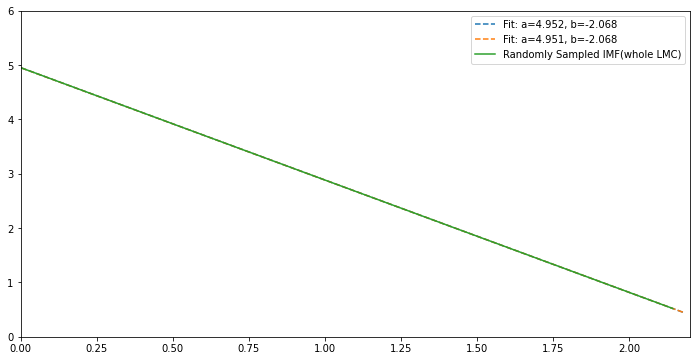

In [17]:
## make fit for the logarithmic data

def fit_function(x, a, b):
    return a+x*b

plt.figure(figsize=(12,6))

#data_random=np.loadtxt('IGIMF_array_random_LMC_M1_5e4_beta_2_PL.txt')
#data_optimal=np.loadtxt('IGIMF_array_optimal_LMC_M1_5e4_beta_2_PL.txt')

#m_input_array=data_random[0]
#IGIMF_array_random_LMC_new=data_random[1]
#IGIMF_array_optimal_LMC_new=data_optimal[1]

#IGIMF_array_random_LMC_new_cut=IGIMF_array_random_LMC_new[IGIMF_array_random_LMC_new>1]
#m_input_array_cut=m_input_array[IGIMF_array_random_LMC_new>1]
#IGIMF_array_optimal_LMC_new_cut=IGIMF_array_optimal_LMC_new[IGIMF_array_random_LMC_new>1]

IGIMF_array_random_30Dor_beta_1_5_cut=IGIMF_array_random_30Dor_beta_1_5[IGIMF_array_random_30Dor_beta_1_5>1]
m_input_array_cut=m_input_array[IGIMF_array_random_30Dor_beta_1_5>1]

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>1]), np.log10(IGIMF_array_random_30Dor_beta_1_5_cut[m_input_array_cut>1]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

popt, pcov = curve_fit(fit_function, np.log10(m_input_array_cut[m_input_array_cut>15]), np.log10(IGIMF_array_random_30Dor_beta_1_5_cut[m_input_array_cut>15]))
print(popt)
perr=np.sqrt(np.diag(pcov))
print(perr)
plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

#plt.figure(figsize=(12,6))

plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_random_30Dor_beta_1_5) , label='Randomly Sampled IMF(whole LMC)')
#plt.plot(np.log10(m_input_array), np.log10(IGIMF_array_optimal_LMC_new) ,label='Optimally Sampled IMF(whole LMC)')
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')
#plt.plot(np.log10(m_input_array), fit_function(np.log10(m_input_array), *popt), label='Fit: a=%5.3f, b=%5.3f' % tuple(popt), linestyle='--')

plt.xlim(0,2.2)
plt.ylim(0,6)

#plt.plot(np.log10(m_input_array), 5.75+np.log10(m_input_array**(-2.5)), label='Fit result from drawn data')

plt.legend()

2.068 is identical to the slope for the optimal sampling case!!

### Making plots/data to showcase that for the case of stacked up clusters, the slopes of optimal and random sampling are basically indistinguishable

In [9]:
## repeat for all LMC clusters (beta=1.5) to test the maximum for spatial randomness!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)
M_ecl_array_30Dor=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_1_5_PL.txt')

#print(M_ecl_array[2300])
#num_stars_array=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_1_5_PL_num_stars_array.txt')

## find the number of clusters such that np.sum(cluster_masses[:n]) is close to 1.15e6
n=0
while np.sum(M_ecl_array_30Dor[:n])<=1.15e6:
    if np.sum(M_ecl_array_30Dor[:int(n+1)])>1.15e6:
        if np.sum(M_ecl_array_30Dor[:int(n+1)])-1.15e6<1.15e6-np.sum(M_ecl_array_30Dor[:n]):
            n=n+1
            break
        else: 
            break
    n=n+1
    ## note that the returned number will always be what is needed as input for
    ## cluster_masses[:int(n)] to be close to 1.15e6 solar masses, is the number of clusters

print('The number of clusters that together have a summed up mass of about 1.15e6 solar masses is:', n)
print(np.sum(M_ecl_array_30Dor[:int(n-1)]),np.sum(M_ecl_array_30Dor[:n]), np.sum(M_ecl_array_30Dor[:int(n+1)]))

## Cut the last clusters
print(n, np.sum(M_ecl_array_30Dor[:n]))

## Cut R136
M_ecl_array_30Dor_cut=M_ecl_array_30Dor[1:n]
print(M_ecl_array_30Dor_cut)

def Cut_Clusters(M_ecl_array):
    n=0
    while np.sum(M_ecl_array[:n])<=1.15e6:
        if np.sum(M_ecl_array[:int(n+1)])>1.15e6:
            if np.sum(M_ecl_array[:int(n+1)])-1.15e6<1.15e6-np.sum(M_ecl_array[:n]):
                n=n+1
                break
            else: 
                break
        n=n+1
    return M_ecl_array[:n]

print(np.sum(Cut_Clusters(M_ecl_array_30Dor)))

print(np.sum(Cut_Clusters(M_ecl_array_30Dor)[1:]))

The number of clusters that together have a summed up mass of about 1.15e6 solar masses is: 32
1130336.3277034948 1156362.588374712 1181927.4028555383
32 1156362.588374712
[48777.55116344 47599.39233888 46463.40952066 45367.61334523
 44310.13037525 43289.19508655 42303.14249385 41350.40135788
 40429.48792192 39539.0001312  38677.61229307 37844.07013998
 37037.18626083 36255.83586971 35498.95288374 34765.52628462
 34054.5967405  33365.25346721 32696.6313097  32047.90802605
 31418.30175833 30807.06867559 30213.50077585 29636.92383487
 29076.69549066 28532.20345352 28002.86383227 27488.11956824
 26987.43896901 26500.31433488 26026.26067122]
1156362.588374712
1106362.588374712


In [8]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_1_5_PL.txt')

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)
IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_1_7_PL.txt')

IGIMF_array_random_beta_1_7=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)
IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_2_PL.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)
IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

M_ecl_array_beta_2_3=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_2_3_PL.txt')

IGIMF_array_random_beta_2_3=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_2_3)[1:], m_input_array)
IGIMF_array_optimal_beta_2_3=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2_3)[1:], m_input_array)

0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11577841156594865
0.1166

In [5]:
#m_input_array=np.logspace(np.log10(0.08), np.log10(150), 2000)
#M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_1_5_PL.txt')#

### Testing the function I used. It was wrong!!!

def Cut_Clusters(M_ecl_array):
    n=0
    while np.sum(M_ecl_array[:n])<=1.15e6:
        if np.sum(M_ecl_array[:int(n+1)])>1.15e6:
            if np.sum(M_ecl_array[:int(n+1)])-1.15e6<1.15e6-np.sum(M_ecl_array[:n]):
                n=n+1
                break
            else: 
                break
        n=n+1
    return M_ecl_array[:n]

#print(Cut_Clusters(M_ecl_array_beta_1_5)[1:])

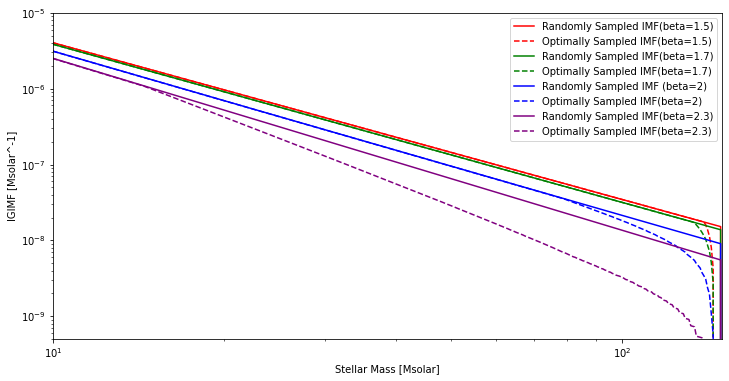

In [12]:
plt.figure(figsize=(12,6))

plt.plot(m_input_array, IGIMF_array_random_beta_1_5/np.sum(IGIMF_array_random_beta_1_5), label='Randomly Sampled IMF(beta=1.5)', color='red')
plt.plot(m_input_array, IGIMF_array_optimal_beta_1_5/np.sum(IGIMF_array_optimal_beta_1_5), label='Optimally Sampled IMF(beta=1.5)', color='red', linestyle='--')

plt.plot(m_input_array, IGIMF_array_random_beta_1_7/np.sum(IGIMF_array_random_beta_1_7), label='Randomly Sampled IMF(beta=1.7)', color='green')
plt.plot(m_input_array, IGIMF_array_optimal_beta_1_7/np.sum(IGIMF_array_optimal_beta_1_7), label='Optimally Sampled IMF(beta=1.7)', color='green', linestyle='--')

plt.plot(m_input_array, IGIMF_array_random_beta_2/np.sum(IGIMF_array_random_beta_2), label='Randomly Sampled IMF (beta=2)', color='blue')
plt.plot(m_input_array, IGIMF_array_optimal_beta_2/np.sum(IGIMF_array_optimal_beta_2), label='Optimally Sampled IMF(beta=2)', color='blue', linestyle='--')

plt.plot(m_input_array, IGIMF_array_random_beta_2_3/np.sum(IGIMF_array_random_beta_2_3), label='Randomly Sampled IMF(beta=2.3)', color='purple')
plt.plot(m_input_array, IGIMF_array_optimal_beta_2_3/np.sum(IGIMF_array_optimal_beta_2_3), label='Optimally Sampled IMF(beta=2.3)', color='purple', linestyle='--')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Stellar Mass [Msolar]')
plt.ylabel('IGIMF [Msolar^-1]')
plt.xlim(10,150)
plt.ylim(5e-10,1e-5)

plt.legend()

Question to me: Why are they shifted?! Should they be shifted?! (I think it may be due to the different number of stars in total that comes in when using different beta.) Since the integral over mass should be equal to the number of stars in total... I dont get it at the moment...
I can normalize them to 1 in order to compare their forms better.

Should I really normalize the random and optimal samples when comparing the results from random to optimal? (Does it even matter? I only shift the function by it right?)

In [13]:
print(np.sum(M_ecl_array_beta_2_3[1:]))
print(np.sum(M_ecl_array_beta_2[1:]))
print(np.sum(M_ecl_array_beta_1_7[1:]))
print(np.sum(M_ecl_array_beta_1_5[1:]))
print(np.sum(IGIMF_array_random_beta_2_3))
print(np.sum(IGIMF_array_random_beta_2))
print(np.sum(IGIMF_array_random_beta_1_7))
print(np.sum(IGIMF_array_random_beta_1_5))
print(np.sum(IGIMF_array_optimal_beta_2_3))
print(np.sum(IGIMF_array_optimal_beta_2))
print(np.sum(IGIMF_array_optimal_beta_1_7))
print(np.sum(IGIMF_array_optimal_beta_1_5))

1150064.2526077356
1149456.049461646
1156340.5024023028
1157042.9354860503
268319642.01821914
230594096.0546707
196726366.91884324
189674150.78921887
298132615.518078
235176678.94026121
198233506.84812185
190858643.18081272


In [14]:
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))
#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_2]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_beta_2_3_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2_3]))
#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_beta_2_3_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_2_3]))

### Drawing the IGIMF samples for the galaxy-wide population

In [5]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
#M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_1_5_PL.txt')

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

#IGIMF_array_random_beta_1_5=IGIMF_random_sampling(M_ecl_array_beta_1_5, m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(M_ecl_array_beta_1_5, m_input_array)

#np.savetxt('IGIMF_array_random_LMC_M1_5e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_optimal_LMC_M1_5e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_5]))

#M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_1_7_PL_all_1SM_stars.txt')

#IGIMF_array_random_beta_1_7=IGIMF_random_sampling(M_ecl_array_beta_1_7, m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(M_ecl_array_beta_1_7, m_input_array)

#np.savetxt('IGIMF_array_random_LMC_M1_5e4_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_optimal_LMC_M1_5e4_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_7]))

M_ecl_array_beta_2=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_2_PL_all_1SM_stars.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2, m_input_array)
IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(M_ecl_array_beta_2, m_input_array)

np.savetxt('IGIMF_array_random_LMC_M1_5e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))
np.savetxt('IGIMF_array_optimal_LMC_M1_5e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_2]))

#M_ecl_array_beta_2_3=np.loadtxt('Clusters_in_LMC_M1_5e4_beta_2_3_PL_all_1SM_stars.txt')

#IGIMF_array_random_beta_2_3=IGIMF_random_sampling(M_ecl_array_beta_2_3, m_input_array)
#IGIMF_array_optimal_beta_2_3=IGIMF_optimal_sampling(M_ecl_array_beta_2_3, m_input_array)

<ipython-input-1-e9f34a4a4e5e>:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08060579478470825


KeyboardInterrupt: 

Beta=2 takes kind of a very long time. First do the results with beta=1.5 and 1.7?!

In [9]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)
#M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_LMC_M1_7e4_beta_1_5_PL_all_1SM_stars.txt')

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

#IGIMF_array_random_beta_1_5=IGIMF_random_sampling(M_ecl_array_beta_1_5, m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(M_ecl_array_beta_1_5, m_input_array)

#np.savetxt('IGIMF_array_random_LMC_M1_7e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_optimal_LMC_M1_7e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_5]))

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_LMC_M1_7e4_beta_1_7_PL_all_1SM_stars.txt')

#IGIMF_array_random_beta_1_7=IGIMF_random_sampling(M_ecl_array_beta_1_7, m_input_array)
IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(M_ecl_array_beta_1_7, m_input_array)

#np.savetxt('IGIMF_array_random_LMC_M1_7e4_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
np.savetxt('IGIMF_array_optimal_LMC_M1_7e4_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_7]))

#M_ecl_array_beta_2=np.loadtxt('Clusters_in_LMC_M1_7e4_beta_2_PL_all_1SM_stars.txt')

#IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2, m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(M_ecl_array_beta_2, m_input_array)

#np.savetxt('IGIMF_array_random_LMC_M1_7e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))
#np.savetxt('IGIMF_array_optimal_LMC_M1_7e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_2]))


<ipython-input-3-1cec3dc015ee>:188: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.19027

In [14]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)

M_ecl_array_beta_2=np.loadtxt('Clusters_in_LMC_M1_7e4_beta_2_PL_all_1SM_stars.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2, m_input_array)

np.savetxt('IGIMF_array_random_LMC_M1_7e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(M_ecl_array_beta_2, m_input_array)

np.savetxt('IGIMF_array_optimal_LMC_M1_7e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_2]))

<ipython-input-1-e9f34a4a4e5e>:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.19027

<ipython-input-3-1cec3dc015ee>:188: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.190271569516354
4.521710872435606
4.879366140047638
5.265310985224307
5.681783038083941
6.131196919317975
6.616158239673152
7.139478706755397
7.

In [13]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)
print(len(m_input_array[m_input_array>1]))

66


In [15]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)

M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_LMC_M1_3e4_beta_1_5_PL_all_1SM_stars.txt')

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(M_ecl_array_beta_1_5, m_input_array)

np.savetxt('IGIMF_array_random_LMC_M1_3e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))

<ipython-input-1-e9f34a4a4e5e>:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11577841156594865
0.1166

In [18]:
### Maybe also do the random samples for the missing 3e4 cluster samples for beta 1.7 and beta 2. Yes!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)

M_ecl_array_beta_2=np.loadtxt('Clusters_in_LMC_M1_3e4_beta_2_PL_all_1SM_stars.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2, m_input_array)

np.savetxt('IGIMF_array_random_LMC_M1_3e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

<ipython-input-1-e9f34a4a4e5e>:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.19027

#### Get the missing 3e4 and 7e4 samples for the 30Dor region without R136

In [ ]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_M1_7e4_beta_1_5_PL.txt')

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))

IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_M1_7e4_beta_1_5_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_5]))

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_M1_7e4_beta_1_7_PL.txt')

IGIMF_array_random_beta_1_7=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))

IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_M1_7e4_beta_1_7_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_1_7]))

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_M1_7e4_beta_2_PL.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_M1_7e4_beta_2_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_2]))

M_ecl_array_beta_2_3=np.loadtxt('Clusters_in_30Dor_M1_7e4_beta_2_3_PL.txt')

IGIMF_array_random_beta_2_3=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_2_3)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_2_3_PL.txt', np.array([m_input_array, IGIMF_array_random_beta_2_3]))

IGIMF_array_optimal_beta_2_3=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2_3)[1:], m_input_array)

#np.savetxt('IGIMF_array_optimal_30Dor_withoutR136_M1_7e4_beta_2_3_PL.txt', np.array([m_input_array, IGIMF_array_optimal_beta_2_3]))

0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11577841156594865
0.1166

### Drawing only R136 to delete it from the IGIMF results later 

In [ ]:
m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)

M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_LMC_M1_3e4_beta_2_PL_all_1SM_stars.txt')

print(M_ecl_array_beta_1_5[:1])

#R136_random_3e4=IGIMF_random_sampling(M_ecl_array_beta_1_5[:1], m_input_array)

R136_random_3e4=IGIMF_optimal_sampling(M_ecl_array_beta_1_5[:1], m_input_array)

#np.savetxt('IGIMF_array_optimal_R136_M1_3e4_100.txt', np.array([m_input_array, R136_random_3e4]))

[29999.96907262]
0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126

### Creating the local ECMF results

In [ ]:
#### Don't forget to exclude the most massive cluster from the samples!!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_3e4_beta_min_0_1_PL_new.txt')

print(len(M_ecl_array_beta_1_5))

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(M_ecl_array_beta_1_5[1:], m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_5e4_beta_min_0_1_PL_new.txt')

IGIMF_array_random_beta_1_7=IGIMF_random_sampling(M_ecl_array_beta_1_7[1:], m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_7e4_beta_min_0_1_PL_new.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2[1:], m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_3e4_beta_min_0_1_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_5e4_beta_min_0_1_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_7e4_beta_min_0_1_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

72
0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11577841156594865
0.1

In [ ]:
#### Don't forget to exclude the most massive cluster from the samples!!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_3e4_beta_0_7_PL_new.txt')

print(len(M_ecl_array_beta_1_5))

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(M_ecl_array_beta_1_5[1:], m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_5e4_beta_0_7_PL_new.txt')

IGIMF_array_random_beta_1_7=IGIMF_random_sampling(M_ecl_array_beta_1_7[1:], m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_7e4_beta_0_7_PL_new.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2[1:], m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_3e4_beta_0_7_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_5e4_beta_0_7_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_7e4_beta_0_7_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

152
0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11577841156594865
0.

In [ ]:
#### Don't forget to exclude the most massive cluster from the samples!!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 100)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_3e4_beta_1_5_PL_new.txt')

print(len(M_ecl_array_beta_1_5))

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(M_ecl_array_beta_1_5[1:], m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_5e4_beta_1_5_PL_new.txt')

IGIMF_array_random_beta_1_7=IGIMF_random_sampling(M_ecl_array_beta_1_7[1:], m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_Mtot_1_15e6_M1_7e4_beta_1_5_PL_new.txt')

IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2[1:], m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_3e4_beta_1_5_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_5e4_beta_1_5_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_Mtot_1_15e6_M1_7e4_beta_1_5_PL_new.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

2930
0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.

<ipython-input-1-e9f34a4a4e5e>:206: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  normalization_constant=M_ecl/quad(IMF_m, m_0, m_max, limit=10000)[0]


0.07999999999999999
0.08632778658701601
0.09315608421266733
0.10052448196491547
0.10847570032296953
0.11705583884198027
0.1263146434289327
0.1363057947593491
0.14708721950698367
0.1587214261909559
0.17127586758749572
0.1848233318074918
0.19944236430723009
0.2152177232790558
0.2322408710622225
0.25061050442302807
0.27043312677869513
0.29182366568263307
0.3149061391511382
0.33981437469475795
0.36669278522311705
0.39569720632174693
0.42699579975527774
0.4607700284353231
0.4972157085057236
0.536544144644926
0.5789833551677529
0.6247793940294534
0.6741977773967482
0.7275250230568376
0.7850703115895575
0.8471672789338189
0.9141759507412723
0.9864848297321879
1.064513148155615
1.1487132984131312
1.2395734559384504
1.3376204095398057
1.443422615614867
1.5575934939459088
1.680794984183588
1.8137413836390979
1.95720348863544
2.1120130634285434
2.2790676626081154
2.4593358349375367
2.6538627388036065
2.8637762018333945
3.090293259810609
3.334727212802804
3.59849523940944
3.883126613276641
4.19027

### Getting results for the stacking in 30Dor for Schechter ECMF?

In [ ]:
### Don't forget to exclude the most massive cluster from the samples!!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_M1_3e4_beta_1_5.txt')

print(len(M_ecl_array_beta_1_5))

print(np.sum(M_ecl_array_beta_1_5))
print(np.sum(Cut_Clusters(M_ecl_array_beta_1_5)[1:]))

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

#IGIMF_array_random_beta_1_5=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_1_5.txt')

print(np.sum(M_ecl_array_beta_1_7))
print(np.sum(Cut_Clusters(M_ecl_array_beta_1_7)[1:]))

#IGIMF_array_random_beta_1_7=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_M1_7e4_beta_1_5.txt')

print(np.sum(M_ecl_array_beta_2))

print(np.sum(Cut_Clusters(M_ecl_array_beta_2)[1:]))

IGIMF_array_random_beta_2=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_3e4_beta_1_5.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_5e4_beta_1_5.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_1_5.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

161
1200984.7494764882
1120774.4990174128
1202211.8701539643
1096867.3791301907
1195809.3926368149
1084827.172565697
0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.1114926

In [ ]:
### Don't forget to exclude the most massive cluster from the samples!!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_M1_3e4_beta_1_7.txt')

print(len(M_ecl_array_beta_1_5))

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

#IGIMF_array_random_beta_1_5=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_3e4_beta_1_7.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_1_7.txt')

#print(len(M_ecl_array_beta_1_7))
#print(np.sum(M_ecl_array_beta_1_7))
#print(np.sum(M_ecl_array_beta_2))

#IGIMF_array_random_beta_1_7=IGIMF_random_sampling(M_ecl_array_beta_1_7[1:], m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_5e4_beta_1_7.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_M1_7e4_beta_1_7.txt')

print(np.sum(M_ecl_array_beta_2))

IGIMF_array_random_beta_2=IGIMF_random_sampling(M_ecl_array_beta_2[1:], m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_3e4_beta_1_7.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_5e4_beta_1_7.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_1_7.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

196
1148586.2600683274
0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.1

In [ ]:
## Don't forget to exclude the most massive cluster from the samples!!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_M1_3e4_beta_2.txt')

print(len(M_ecl_array_beta_1_5))
print(np.sum(M_ecl_array_beta_1_5))

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_3e4_beta_2.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_M1_5e4_beta_2.txt')

print(np.sum(M_ecl_array_beta_1_7))

IGIMF_array_random_beta_1_7=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_5e4_beta_2.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_M1_7e4_beta_2.txt')

print(np.sum(M_ecl_array_beta_2))

IGIMF_array_random_beta_2=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_3e4_beta_2.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_5e4_beta_2.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_2.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

540
1200303.256244544
0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.11

In [ ]:
## Don't forget to exclude the most massive cluster from the samples!!

m_input_array=np.logspace(np.log10(0.08), np.log10(150), 1000)
M_ecl_array_beta_1_5=np.loadtxt('Clusters_in_30Dor_M1_3e4.txt')

print(len(M_ecl_array_beta_1_5))
print(np.sum(M_ecl_array_beta_1_5))

## Calculate the IGIMF for the optimally sampled IMF and the randomly sampled IMF

IGIMF_array_random_beta_1_5=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)
#IGIMF_array_optimal_beta_1_5=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_5)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_3e4_beta_2_3.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))

M_ecl_array_beta_1_7=np.loadtxt('Clusters_in_30Dor_M1_5e4.txt')

print(np.sum(M_ecl_array_beta_1_7))

IGIMF_array_random_beta_1_7=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)
#IGIMF_array_optimal_beta_1_7=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_1_7)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_5e4_beta_2_3.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))

M_ecl_array_beta_2=np.loadtxt('Clusters_in_30Dor_M1_7e4.txt')

print(np.sum(M_ecl_array_beta_2))

IGIMF_array_random_beta_2=IGIMF_random_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)
#IGIMF_array_optimal_beta_2=IGIMF_optimal_sampling(Cut_Clusters(M_ecl_array_beta_2)[1:], m_input_array)

#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_3e4_beta_2.txt', np.array([m_input_array, IGIMF_array_random_beta_1_5]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_5e4_beta_2.txt', np.array([m_input_array, IGIMF_array_random_beta_1_7]))
#np.savetxt('IGIMF_array_random_30Dor_withoutR136_M1_7e4_beta_2_3.txt', np.array([m_input_array, IGIMF_array_random_beta_2]))

2830
1199968.6239719598
0.07999999999999999
0.08060579478470825
0.08121617691093126
0.08183118111601359
0.08245084240034607
0.08307519602935773
0.08370427753552276
0.08433812272038267
0.08497676765658384
0.08562024868993039
0.0862686024414527
0.08692186580949149
0.08758007597179775
0.0882432703876486
0.0889114867999791
0.08958476323753016
0.09026313801701291
0.09094664974528928
0.0916353373215691
0.09232923993962396
0.09302839709001774
0.09373284856235402
0.09444263444754057
0.09515779514007093
0.09587837134032334
0.09660440405687697
0.09733593460884579
0.09807300462823008
0.09881565606228572
0.09956393117591146
0.10031787255405424
0.10107752310413266
0.10184292605847907
0.10261412497679977
0.10339116374865412
0.10417408659595227
0.10496293807547197
0.10575776308139419
0.1065586068478582
0.10736551495153583
0.1081785333142253
0.10899770820546464
0.10982308624516494
0.11065471440626352
0.11149264001739724
0.11233691076559593
0.11318757469899637
0.11404468022957674
0.11490827613591173
0.